# Phase 2: Sentiment Scoring - VADER vs FinBERT Comparison

## Objective

Transform 52,974 raw news headlines into daily, ticker-specific sentiment time series using:
- **VADER** (Lexicon-based pproach)
- **FinBERT** (Transformer-based approach)

This enables a direct comparison of baseline vs state-of-the-art sentiment analysis for financial text.

## Pipeline Overview

```
News (53k articles)
    ↓
1. Entity Resolution (yfinance keyword matching)
    ↓
2. News Attribution (assign to tickers or MARKET_GENERAL)
    ↓
3. VADER Scoring (lexicon-based, CPU)
    ↓
4. FinBERT Scoring (transformer-based, GPU)
    ↓
5. Validation & Comparison
    ↓
6. Daily Aggregation by Ticker
    ↓
Output: sentiment_scores_60.csv + market_sentiment_general.csv
```

---

## 1. Environment & Setup

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

import yfinance as yf

import matplotlib.pyplot as plt
import seaborn as sns

import os
import re
from tqdm import tqdm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'  GPU detected: {torch.cuda.get_device_name(0)}')
    print(f'  CUDA version: {torch.version.cuda}')
    print(f'  Memory allocated: {torch.cuda.memory_allocated(0) / 1024**2:.2f} MB')
    print(f'  Memory reserved: {torch.cuda.memory_reserved(0) / 1024**2:.2f} MB')
else:
    device = torch.device('cpu')

print(f'\nDevice set to: {device}')

  GPU detected: Tesla T4
  CUDA version: 12.8
  Memory allocated: 0.00 MB
  Memory reserved: 0.00 MB

Device set to: cuda


In [4]:
project_root = '/content/drive/MyDrive/market-sentiment-impact-analysis'

data_processed = os.path.join(project_root, 'data', 'processed')
data_tickers = os.path.join(project_root, 'data', 'tickers')

os.makedirs(data_processed, exist_ok=True)

print(f"Project Root: {project_root}")
print(f"Processed Data: {data_processed}")
print(f"Tickers Data: {data_tickers}")

Project Root: /content/drive/MyDrive/market-sentiment-impact-analysis
Processed Data: /content/drive/MyDrive/market-sentiment-impact-analysis/data/processed
Tickers Data: /content/drive/MyDrive/market-sentiment-impact-analysis/data/tickers


---

## 2. Load Input Data

In [5]:
news_path = os.path.join(data_processed, 'daily_news_cleaned.csv')

print(f'Loading news data from: {news_path}')
news_df = pd.read_csv(news_path)

news_df['date'] = pd.to_datetime(news_df['date'])

print(f'\nNews data loaded:')
print(f'  Records: {len(news_df):,}')
print(f'  Date range: {news_df['date'].min().date()} to {news_df['date'].max().date()}')
print(f'  Sources: {news_df['source'].value_counts().to_dict()}')
print(f'\nColumns: {list(news_df.columns)}')
print(f'\nSample:')
print(news_df.head(3))

Loading news data from: /content/drive/MyDrive/market-sentiment-impact-analysis/data/processed/daily_news_cleaned.csv

News data loaded:
  Records: 52,974
  Date range: 2018-01-02 to 2020-07-18
  Sources: {'Reuters': 32673, 'Guardian': 17516, 'CNBC': 2785}

Columns: ['date', 'source', 'final_text']

Sample:
                       date    source                                         final_text
0 2018-01-02 00:00:00+00:00  Guardian  Former advertising executive reveals junk food...
1 2018-01-02 00:00:00+00:00  Guardian  Transport secretary ‘running scared’ as he fli...
2 2018-01-02 00:00:00+00:00  Guardian  Good for factories, bad for shoppers: a Brexit...


In [6]:
all_betas_path = os.path.join(data_tickers, 'all_betas.csv')

print(f'Loading ticker metadata from all_betas.csv...')
all_tickers_df = pd.read_csv(all_betas_path)

stock_returns_path = os.path.join(data_processed, 'stock_returns_60.csv')
stock_returns = pd.read_csv(stock_returns_path)
ticker_list = stock_returns['Ticker'].unique().tolist()

all_tickers_df = all_tickers_df[all_tickers_df['Ticker'].isin(ticker_list)].copy()

print(f'\nTickers loaded:')
print(f'  Total: {len(ticker_list)}')
print(f'  Unique tickers in metadata: {len(all_tickers_df)}')
print(f'\nSample tickers: {ticker_list[:10]}')

Loading ticker metadata from all_betas.csv...

Tickers loaded:
  Total: 60
  Unique tickers in metadata: 60

Sample tickers: ['AEP', 'AMP', 'APA', 'BA', 'C', 'CAG', 'CCL', 'CHD', 'CHRW', 'CL']


---

## 3. Entity Resolution

In [7]:
print('Fetching company names from Yahoo Finance...')

company_names = {}
failed_tickers = []

for ticker in tqdm(ticker_list):
    try:
        stock = yf.Ticker(ticker)
        info = stock.info

        name = info.get('shortName') or info.get('longName') or ticker
        company_names[ticker] = name

    except Exception as e:
        company_names[ticker] = ticker
        failed_tickers.append(ticker)

print(f'\n  Downloaded names for {len(company_names)} tickers')
if failed_tickers:
    print(f"   Failed to fetch: {failed_tickers}")

print(f'\nSample company names:')
for ticker in list(company_names.keys())[:5]:
    print(f'  {ticker}: {company_names[ticker]}')

Fetching company names from Yahoo Finance...


100%|██████████| 60/60 [00:05<00:00, 10.89it/s]


  Downloaded names for 60 tickers

Sample company names:
  AEP: American Electric Power Company
  AMP: Ameriprise Financial, Inc.
  APA: APA Corporation
  BA: Boeing Company (The)
  C: Citigroup, Inc.


In [8]:
def clean_company_name(name):
    if not isinstance(name, str):
        return str(name)

    suffixes = [
        r',?\s+Inc\.?$',
        r',?\s+Corporation$',
        r',?\s+Corp\.?$',
        r',?\s+Company$',
        r',?\s+Co\.?$',
        r',?\s+Ltd\.?$',
        r',?\s+Limited$',
        r',?\s+Plc$',
        r',?\s+PLC$',
        r',?\s+LLC$',
        r',?\s+L\.P\.$',
        r',?\s+LP$',
        r',?\s+Group$',
        r',?\s+Holdings?$',
        r'\s+\(The\)$',
        r',?\s+& Co\.?$'
    ]

    cleaned = name
    for suffix in suffixes:
        cleaned = re.sub(suffix, '', cleaned, flags=re.IGNORECASE)

    return cleaned.strip()

company_names_clean = {ticker: clean_company_name(name)
                        for ticker, name in company_names.items()}

print('Company name cleaning:')
print('\nBefore → After:')
for ticker in list(company_names.keys())[:10]:
    original = company_names[ticker]
    cleaned = company_names_clean[ticker]
    if original != cleaned:
        print(f'  {ticker}: {original} → {cleaned}')
    else:
        print(f'  {ticker}: {original} (no change)')

Company name cleaning:

Before → After:
  AEP: American Electric Power Company → American Electric Power
  AMP: Ameriprise Financial, Inc. → Ameriprise Financial
  APA: APA Corporation → APA
  BA: Boeing Company (The) → Boeing Company
  C: Citigroup, Inc. → Citigroup
  CAG: ConAgra Brands, Inc. → ConAgra Brands
  CCL: Carnival Corporation → Carnival
  CHD: Church & Dwight Company, Inc. → Church & Dwight
  CHRW: C.H. Robinson Worldwide, Inc. → C.H. Robinson Worldwide
  CL: Colgate-Palmolive Company → Colgate-Palmolive


In [9]:
def create_keyword_dict(ticker_list, company_names_clean, all_tickers_df):
    """
    multi-level keyword dictionary:
    1. Direct: Company-specific keywords
    2. Sector: Industry/sector keywords
    3. Thematic: Major events/themes
    """
    keywords = {}
    sector_keywords = {}
    thematic_keywords = {}

    for ticker in ticker_list:
        name = company_names_clean.get(ticker, ticker)

        keyword_list = [ticker, name]

        words = name.split()
        if len(words) > 1:
            first_word = words[0]
            if len(first_word) > 3:
                keyword_list.append(first_word)

        manual_mappings = {
            'C': ['Citigroup', 'Citi'],
            'PG': ['P&G', 'Procter', 'Procter & Gamble', 'The Procter & Gamble Company'],
            'WMT': ['Walmart', 'Wal-Mart'],
            'BA': ['Boeing'],
            'VZ': ['Verizon'],
            'COF': ['Capital One'],
            'COST': ['Costco'],
            'DG': ['Dollar General'],
            'AMP': ['Ameriprise'],
            'APA': ['APA Corp'],
            'CVNA': ['Carvana'],
            'CCL': ['Carnival'],
            'RCL': ['Royal Caribbean'],
            'MGM': ['MGM Resorts'],
            'HAL': ['Halliburton'],
            'OXY': ['Occidental'],
            'DVN': ['Devon'],
            'MPC': ['Marathon', 'Marathon Petroleum'],
            'WDC': ['Western Digital'],
            'PRU': ['Prudential', 'Prudential Financial'],
            'LRCX': ['Lam Research'],
            'SYF': ['Synchrony'],
            'WYNN': ['Wynn'],
            'OKE': ['Oneok'],
            'KEY': ['KeyCorp', 'KeyBank'],
            'IVZ': ['Invesco'],
            'FANG': ['Diamondback', 'Diamondback Energy'],
            'TTD': ['Trade Desk'],
            'URI': ['United Rentals'],
            'FCX': ['Freeport', 'Freeport-McMoRan'],
            'GIS': ['General Mills'],
            'HRL': ['Hormel', 'Hormel Foods'],
            'CAG': ['Conagra', 'Conagra Brands'],
            'CHD': ['Church & Dwight'],
            'KMB': ['Kimberly-Clark', 'Kimberly Clark', 'Kimberly-Clark Corp'],
            'CLX': ['Clorox', 'Clorox Co', 'The Clorox Company'],
            'KR': ['Kroger', 'Kroger Co'],
            'CPB': ['Campbell', 'Campbell\'s', 'Campbell Soup'],
            'SJM': ['Smucker', 'J.M. Smucker', 'J.M. Smucker'],
            'DPZ': ['Domino\'s', 'Dominos'],
            'KDP': ['Keurig', 'Keurig Dr Pepper'],
            'ED': ['Con Ed', 'ConEd', 'Consolidated Edison'],
            'AEP': ['American Electric', 'American Electric Power', 'AEP'],
            'CMS': ['CMS Energy'],
            'WEC': ['WEC Energy'],
            'LNT': ['Alliant'],
            'GILD': ['Gilead'],
            'MKC': ['McCormick', 'McCormick & Co'],
            'CL': ['Colgate', 'Colgate-Palmolive'],
            'GEN': ['Gen Digital'],
            'CHRW': ['C.H. Robinson'],
            'PSA': ['Public Storage'],
            'EXR': ['Extra Space', 'Extra Space Storage'],
            'NEM': ['Newmont', 'Newmont Corp'],
            'SW': ['Smurfit', 'Smurfit Westrock'],
            'ON': ['ON Semi', 'ON Semiconductor'],
            'NCLH': ['Norwegian Cruise'],
            'TPR': ['Tapestry'],
            'TRGP': ['Targa', 'Targa Resources']
        }

        if ticker in manual_mappings:
            keyword_list.extend(manual_mappings[ticker])

        keyword_list = list(set([k.strip() for k in keyword_list if k.strip()]))
        keywords[ticker] = keyword_list

    ticker_to_sector = dict(zip(all_tickers_df['Ticker'], all_tickers_df['GICS Sector']))

    sector_keyword_map = {
        'Energy': ['oil', 'crude', 'petroleum', 'drilling', 'fracking', 'shale', 'refining',
                   'opec', 'energy sector', 'oil prices', 'natural gas'],

        'Financials': ['bank', 'banking', 'financial services', 'lending', 'credit card',
                       'mortgage', 'interest rate', 'fed rate', 'basel', 'capital requirements'],

        'Consumer Discretionary': ['retail', 'consumer spending', 'shopping', 'e-commerce',
                                   'cruise', 'casino', 'gaming', 'resort', 'leisure',
                                   'tourism', 'travel', 'vacation'],

        'Consumer Staples': ['grocery', 'food', 'beverage', 'packaged goods', 'supermarket',
                            'consumer goods', 'household products'],

        'Industrials': ['manufacturing', 'industrial', 'construction', 'aerospace',
                       'defense', 'machinery', 'equipment rental'],

        'Information Technology': ['tech', 'semiconductor', 'chip', 'software', 'hardware',
                                   'digital', 'silicon', 'foundry', 'memory'],

        'Materials': ['mining', 'metals', 'copper', 'gold', 'commodities', 'materials sector',
                     'raw materials'],

        'Utilities': ['utility', 'electric', 'power', 'gas', 'water', 'energy grid',
                     'renewable energy'],

        'Real Estate': ['real estate', 'property', 'reit', 'commercial property',
                       'storage', 'warehouse'],

        'Health Care': ['healthcare', 'pharma', 'pharmaceutical', 'biotech', 'drug',
                       'medical', 'fda approval'],

        'Communication Services': ['telecom', 'wireless', 'broadband', '5g', 'internet service',
                                   'advertising', 'media']
    }

    # reverse mapping: keyword -> list of tickers in that sector
    for sector, keywords_list in sector_keyword_map.items():
        for keyword in keywords_list:
            if keyword not in sector_keywords:
                sector_keywords[keyword] = []

            tickers_in_sector = [t for t, s in ticker_to_sector.items() if s == sector]
            sector_keywords[keyword].extend(tickers_in_sector)


    thematic_mappings = {
        # COVID-19 impact
        'covid|pandemic|coronavirus|lockdown|quarantine': {
            'positive': [],
            'negative': ['CCL', 'RCL', 'NCLH', 'MGM', 'WYNN', 'BA', 'URI']
        },

        'oil price|crude price|opec': {
            'positive': ['APA', 'OXY', 'DVN', 'FANG', 'TRGP', 'HAL', 'MPC'],
            'negative': []
        },

        'interest rate|fed rate|federal reserve rate': {
            'positive': ['C', 'COF', 'KEY', 'PRU', 'SYF', 'AMP', 'IVZ'],
            'negative': ['ED', 'AEP', 'CMS', 'WEC', 'LNT', 'PSA', 'EXR']
        },

        'chip shortage|semiconductor shortage': {
            'positive': ['ON', 'LRCX', 'WDC'],
            'negative': []
        },

        'inflation|price increase|cost pressure': {
            'positive': ['NEM', 'FCX'],
            'negative': ['WMT', 'COST', 'DG', 'KR']
        },

        'consumer confidence|consumer spending|retail sales': {
            'positive': ['WMT', 'COST', 'DG', 'DPZ', 'TPR'],
            'negative': []
        },

        'supply chain|logistics|shipping': {
            'positive': ['CHRW', 'URI'],
            'negative': ['WMT', 'COST', 'DG']
        }
    }

    for pattern, impact_dict in thematic_mappings.items():
        thematic_keywords[pattern] = impact_dict

    return keywords, sector_keywords, thematic_keywords

keywords, sector_keywords, thematic_keywords = create_keyword_dict(
    ticker_list, company_names_clean, all_tickers_df
)

# samples
print(f'Multi-level keyword dictionary created:')
print(f'  Direct company keywords: {len(keywords)} tickers')
print(f'  Sector keywords: {len(sector_keywords)} sector terms')
print(f'  Thematic keywords: {len(thematic_keywords)} themes')
print(f'\nSample direct mappings:')
for ticker in list(keywords.keys())[:5]:
    print(f'  {ticker}: {keywords[ticker]}')
print(f'\nSample sector keyword:')
print(f"  'cruise' → {sector_keywords.get('cruise', [])} tickers")
print(f'\nSample thematic mapping:')
print(f'  COVID-19 → negative impact: {thematic_keywords[list(thematic_keywords.keys())[0]]['negative']}')

Multi-level keyword dictionary created:
  Direct company keywords: 60 tickers
  Sector keywords: 90 sector terms
  Thematic keywords: 7 themes

Sample direct mappings:
  AEP: ['AEP', 'American', 'American Electric', 'American Electric Power']
  AMP: ['AMP', 'Ameriprise', 'Ameriprise Financial']
  APA: ['APA Corp', 'APA']
  BA: ['BA', 'Boeing Company', 'Boeing']
  C: ['C', 'Citi', 'Citigroup']

Sample sector keyword:
  'cruise' → ['NCLH', 'CVNA', 'CCL', 'RCL', 'MGM', 'TPR', 'WYNN', 'DPZ'] tickers

Sample thematic mapping:
  COVID-19 → negative impact: ['CCL', 'RCL', 'NCLH', 'MGM', 'WYNN', 'BA', 'URI']


---

## 4. News Filtering & Attribution

In [10]:
# find ticker matches in text (multi-levels)

def find_ticker_matches(text, keywords_dict, sector_keywords_dict, thematic_keywords_dict):
    """
    Find all tickers mentioned in text using 3 levels:
    1. Direct, 2. Sector, 3. Thematic
    """
    if not isinstance(text, str):
        return {}

    text_lower = text.lower()
    matches = {}

    for ticker, keyword_list in keywords_dict.items():
        for keyword in keyword_list:
            pattern = r'\b' + re.escape(keyword.lower()) + r'\b'
            if re.search(pattern, text_lower):
                if ticker not in matches:
                    matches[ticker] = []
                matches[ticker].append('direct')
                break

    # Sector Keywords
    for sector_keyword, ticker_list in sector_keywords_dict.items():
        pattern = r'\b' + re.escape(sector_keyword.lower()) + r'\b'
        if re.search(pattern, text_lower):
            for ticker in ticker_list:
                if ticker not in matches:
                    matches[ticker] = []

                if 'direct' not in matches[ticker]:
                    matches[ticker].append('sector')

    # Thematic Keywords
    for theme_pattern, impact_dict in thematic_keywords_dict.items():
        if re.search(theme_pattern, text_lower, re.IGNORECASE):
            if impact_dict.get('positive'):
                for ticker in impact_dict['positive']:
                    if ticker not in matches:
                        matches[ticker] = []
                    if 'direct' not in matches[ticker] and 'sector' not in matches[ticker]:
                        matches[ticker].append('thematic_positive')

            if impact_dict.get('negative'):
                for ticker in impact_dict['negative']:
                    if ticker not in matches:
                        matches[ticker] = []
                    if 'direct' not in matches[ticker] and 'sector' not in matches[ticker]:
                        matches[ticker].append('thematic_negative')

    return matches

# Test the multi-level matching
test_texts = [
    'Royal Caribbean announces new ship',
    'Cruise industry faces COVID-19 restrictions',
    'Oil prices surge on OPEC production cuts',
    'Federal Reserve raises interest rates',
    'Semiconductor shortage impacts tech sector'
]

print("Testing multi-level keyword matching:\n")
for text in test_texts:
    matches = find_ticker_matches(text, keywords, sector_keywords, thematic_keywords)
    print(f'Text: {text}')
    if matches:
        for ticker, match_types in matches.items():
            print(f"  → {ticker} ({', '.join(match_types)})")
    else:
        print(f'  → No matches (MARKET_GENERAL)')
    print()

Testing multi-level keyword matching:

Text: Royal Caribbean announces new ship
  → RCL (direct)

Text: Cruise industry faces COVID-19 restrictions
  → NCLH (sector)
  → CVNA (sector)
  → CCL (sector)
  → RCL (sector)
  → MGM (sector)
  → TPR (sector)
  → WYNN (sector)
  → DPZ (sector)
  → BA (thematic_negative)
  → URI (thematic_negative)

Text: Oil prices surge on OPEC production cuts
  → ON (direct)
  → APA (sector, sector, sector)
  → TRGP (sector, sector, sector)
  → HAL (sector, sector, sector)
  → OXY (sector, sector, sector)
  → DVN (sector, sector, sector)
  → MPC (sector, sector, sector)
  → OKE (sector, sector, sector)
  → FANG (sector, sector, sector)

Text: Federal Reserve raises interest rates
  → C (thematic_positive)
  → COF (thematic_positive)
  → KEY (thematic_positive)
  → PRU (thematic_positive)
  → SYF (thematic_positive)
  → AMP (thematic_positive)
  → IVZ (thematic_positive)
  → ED (thematic_negative)
  → AEP (thematic_negative)
  → CMS (thematic_negative)
  → WE

In [11]:
# Apply attribution to all news articles
print('Attributing news to tickers with multi-level matching...')
print('  Processing news articles...\n')

news_df['matched_tickers_dict'] = news_df['final_text'].apply(
    lambda x: find_ticker_matches(x, keywords, sector_keywords, thematic_keywords)
)

news_df['matched_tickers'] = news_df['matched_tickers_dict'].apply(
    lambda x: list(x.keys()) if x else []
)
news_df['match_count'] = news_df['matched_tickers'].apply(len)

print('Attribution results:')
print(f'  Articles with 0 matches (MARKET_GENERAL): {(news_df['match_count'] == 0).sum():,}')
print(f'  Articles with 1 match: {(news_df['match_count'] == 1).sum():,}')
print(f'  Articles with 2+ matches: {(news_df['match_count'] >= 2).sum():,}')
print(f'  Max matches in single article: {news_df['match_count'].max()}')

all_match_types = []
for match_dict in news_df['matched_tickers_dict']:
    for ticker, types in match_dict.items():
        all_match_types.extend(types)

from collections import Counter
match_type_counts = Counter(all_match_types)
print('\nMatch type distribution:')
for match_type, count in match_type_counts.most_common():
    print(f"  {match_type}: {count:,}")

print('\nMatch count distribution:')
print(news_df['match_count'].value_counts().sort_index().head(10))

Attributing news to tickers with multi-level matching...
  Processing news articles...

Attribution results:
  Articles with 0 matches (MARKET_GENERAL): 15,539
  Articles with 1 match: 12,895
  Articles with 2+ matches: 24,540
  Max matches in single article: 32

Match type distribution:
  sector: 125,543
  thematic_negative: 43,263
  direct: 39,230
  thematic_positive: 4,389

Match count distribution:
match_count
0    15539
1    12895
2     4821
3     1731
4     1954
5     1013
6     1038
7     2033
8     3894
9     3351
Name: count, dtype: int64


In [12]:
# Explode the df - create one row per ticker match
# Articles mentioning multiple companies will have multiple rows

print('Expanding articles with multiple ticker matches...')

news_with_matches = news_df[news_df['match_count'] > 0].copy()
news_no_matches = news_df[news_df['match_count'] == 0].copy()

expanded_rows = []
for idx, row in news_with_matches.iterrows():
    for ticker, match_types in row['matched_tickers_dict'].items():
        expanded_rows.append({
            'date': row['date'],
            'source': row['source'],
            'final_text': row['final_text'],
            'Ticker': ticker,
            'match_type': ','.join(match_types),
            'is_direct': 'direct' in match_types
        })

news_attributed = pd.DataFrame(expanded_rows)

# Add rows for MARKET_GENERAL
news_no_matches['Ticker'] = 'MARKET_GENERAL'
news_no_matches['match_type'] = 'none'
news_no_matches['is_direct'] = False
news_market = news_no_matches[['date', 'source', 'final_text', 'Ticker', 'match_type', 'is_direct']]

news_final = pd.concat([news_attributed, news_market], ignore_index=True)

print('\nExpansion complete:')
print(f'  Original articles: {len(news_df):,}')
print(f'  Attributed rows (after expansion): {len(news_final):,}')
print(f'  Expansion factor: {len(news_final) / len(news_df):.2f}x')
print('\nBreakdown:')
print(f'  Ticker-specific: {(news_final['Ticker'] != 'MARKET_GENERAL').sum():,}')
print(f'    Direct mentions: {news_final['is_direct'].sum():,}')
print(f'    Indirect (sector/thematic): {(~news_final['is_direct'] & (news_final['Ticker'] != 'MARKET_GENERAL')).sum():,}')
print(f'  Market general: {(news_final['Ticker'] == 'MARKET_GENERAL').sum():,}')

Expanding articles with multiple ticker matches...

Expansion complete:
  Original articles: 52,974
  Attributed rows (after expansion): 206,023
  Expansion factor: 3.89x

Breakdown:
  Ticker-specific: 190,484
    Direct mentions: 39,230
    Indirect (sector/thematic): 151,254
  Market general: 15,539


In [13]:
# ticker coverage by match type
ticker_specific = news_final[news_final['Ticker'] != 'MARKET_GENERAL'].copy()

ticker_counts = ticker_specific['Ticker'].value_counts()
print(f'Ticker-specific news coverage:')
print(f' Total tickers with news: {len(ticker_counts)}')
print(f'  Mean articles per ticker: {ticker_counts.mean():.1f}')
print(f'  Median articles per ticker: {ticker_counts.median():.1f}')
print(f'  Min articles per ticker: {ticker_counts.min()}')
print(f'  Max articles per ticker: {ticker_counts.max()}')

print('\nTop 10 most mentioned stocks (all match types):')
print(ticker_counts.head(10))

direct_mentions = ticker_specific[ticker_specific['is_direct']]['Ticker'].value_counts()
print('\nTop 10 most mentioned stocks (direct mentions only):')
print(direct_mentions.head(10))

# indirect mentions (sector/thematic)
indirect_mentions = ticker_specific[~ticker_specific['is_direct']]['Ticker'].value_counts()
print('\nTop 10 stocks most affected by sector/thematic news:')
print(indirect_mentions.head(10))

print('\nMatch type breakdown:')
print(ticker_specific['match_type'].value_counts())

print('\nBottom 10 least mentioned stocks (all types):')
print(ticker_counts.tail(10))

Ticker-specific news coverage:
 Total tickers with news: 60
  Mean articles per ticker: 3174.7
  Median articles per ticker: 2374.5
  Min articles per ticker: 388
  Max articles per ticker: 28315

Top 10 most mentioned stocks (all match types):
Ticker
ON      28315
URI      9214
BA       7756
RCL      7063
NCLH     6969
MGM      6914
WYNN     6913
CCL      6911
KEY      4307
COF      4243
Name: count, dtype: int64

Top 10 most mentioned stocks (direct mentions only):
Ticker
ON      27634
URI      2876
BA       1410
PSA       993
AEP       894
GIS       853
COST      737
KEY       621
DG        600
COF       599
Name: count, dtype: int64

Top 10 stocks most affected by sector/thematic news:
Ticker
RCL     6894
MGM     6894
CCL     6893
WYNN    6882
NCLH    6880
BA      6346
URI     6338
IVZ     3747
PRU     3746
SYF     3746
Name: count, dtype: int64

Match type breakdown:
match_type
sector                                       86303
thematic_negative                            43140
di

---

## 5. Model A: VADER Sentiment Scoring

**VADER** (Valence Aware Dictionary and sEntiment Reasoner)
- **Type**: Lexicon-based
- **Approach**: Rules + word dictionary
- **Output**: Compound score from -1 (very negative) to +1 (very positive)

In [14]:
print('Initializing VADER sentiment analyzer...')
vader_analyzer = SentimentIntensityAnalyzer()

test_sentences = [
    'Stock surges to all-time high on strong earnings',
    'Company reports massive losses, CEO resigns',
    'Shares trade flat in quiet session',
    'Analyst upgrades stock, raises price target',
    'Regulatory probe triggers sharp selloff'
]

print('\nVADER test on sample financial sentences:')
for sentence in test_sentences:
    scores = vader_analyzer.polarity_scores(sentence)
    compound = scores['compound']
    sentiment = 'Positive' if compound > 0.05 else 'Negative' if compound < -0.05 else 'Neutral'
    print(f'\n  Text: {sentence}')
    print(f'  Compound: {compound:.3f} ({sentiment})')
    print(f'  Breakdown: Pos={scores['pos']:.2f}, Neg={scores['neg']:.2f}, Neu={scores['neu']:.2f}')

Initializing VADER sentiment analyzer...

VADER test on sample financial sentences:

  Text: Stock surges to all-time high on strong earnings
  Compound: 0.511 (Positive)
  Breakdown: Pos=0.32, Neg=0.00, Neu=0.68

  Text: Company reports massive losses, CEO resigns
  Compound: -0.612 (Negative)
  Breakdown: Pos=0.00, Neg=0.56, Neu=0.44

  Text: Shares trade flat in quiet session
  Compound: 0.296 (Positive)
  Breakdown: Pos=0.31, Neg=0.00, Neu=0.69

  Text: Analyst upgrades stock, raises price target
  Compound: 0.000 (Neutral)
  Breakdown: Pos=0.00, Neg=0.00, Neu=1.00

  Text: Regulatory probe triggers sharp selloff
  Compound: 0.000 (Neutral)
  Breakdown: Pos=0.00, Neg=0.00, Neu=1.00


In [15]:
print('\nApplying VADER to all news articles...')
print(f'Processing {len(news_final):,} rows...')

import time
start_time = time.time()

news_final['vader_scores'] = news_final['final_text'].apply(
    lambda x: vader_analyzer.polarity_scores(x)
)
news_final['vader_score'] = news_final['vader_scores'].apply(
    lambda x: x['compound']
)

elapsed = time.time() - start_time

print(f'  Time elapsed: {elapsed:.2f} seconds')
print(f'  Processing rate: {len(news_final) / elapsed:,.0f} articles/second')

news_final.drop('vader_scores', axis=1, inplace=True)


Applying VADER to all news articles...
Processing 206,023 rows...
  Time elapsed: 35.54 seconds
  Processing rate: 5,797 articles/second


VADER Score Distribution:
count    206023.000000
mean          0.007909
std           0.524295
min          -0.983700
25%          -0.421500
50%           0.000000
75%           0.440400
max           0.981600
Name: vader_score, dtype: float64


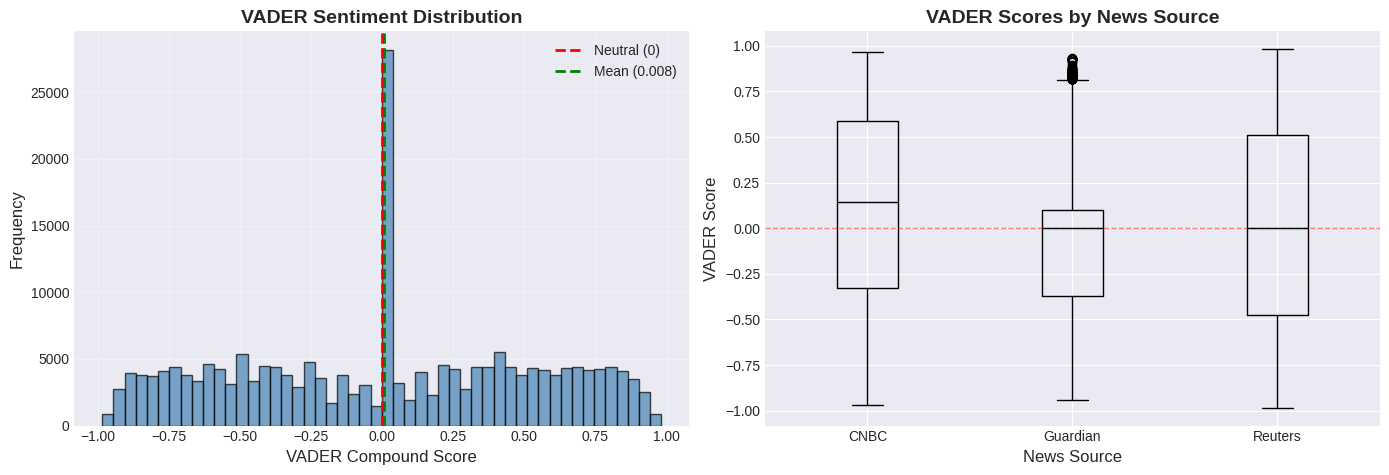


Sentiment Breakdown (using ±0.05 threshold):
  Positive: 90,147 (43.8%)
  Negative: 86,056 (41.8%)
  Neutral: 29,820 (14.5%)


In [20]:
# VADER score distribution
print('VADER Score Distribution:')
print(news_final['vader_score'].describe())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(news_final['vader_score'], bins=50, alpha=0.7, edgecolor='black', color='steelblue')
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='Neutral (0)')
axes[0].axvline(news_final['vader_score'].mean(), color='green', linestyle='--',
                linewidth=2, label=f'Mean ({news_final["vader_score"].mean():.3f})')
axes[0].set_xlabel('VADER Compound Score', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('VADER Sentiment Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

news_final.boxplot(column='vader_score', by='source', ax=axes[1], color='black')
axes[1].set_xlabel('News Source', fontsize=12)
axes[1].set_ylabel('VADER Score', fontsize=12)
axes[1].set_title('VADER Scores by News Source', fontsize=14, fontweight='bold')
axes[1].axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)
plt.suptitle('')

plt.tight_layout()
plt.show()

# Sentiment categories
positive = (news_final['vader_score'] > 0.05).sum()
negative = (news_final['vader_score'] < -0.05).sum()
neutral = ((news_final['vader_score'] >= -0.05) & (news_final['vader_score'] <= 0.05)).sum()

print('\nSentiment Breakdown (using ±0.05 threshold):')
print(f'  Positive: {positive:,} ({positive/len(news_final)*100:.1f}%)')
print(f'  Negative: {negative:,} ({negative/len(news_final)*100:.1f}%)')
print(f'  Neutral: {neutral:,} ({neutral/len(news_final)*100:.1f}%)')

---

## 6. Model B: FinBERT Sentiment Scoring

**FinBERT** (Financial BERT)
- **Type**: Transformer-based (deep learning)
- **Approach**: Pre-trained on financial text
- **Output**: Probabilities for positive/negative/neutral → compound score

In [21]:
# Load FinBERT model and tokenizer
print('Loading FinBERT model and tokenizer...')

model_name = "ProsusAI/finbert"

tokenizer = AutoTokenizer.from_pretrained(model_name)
print('  Tokenizer loaded')

model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.to(device)
model.eval()
print(f'  Model loaded and moved to {device}')

print('\nModel configuration:')
print(f'  Model name: {model_name}')
print(f'  Number of labels: {model.config.num_labels}')
print(f'  Label mapping: {model.config.id2label}')
print(f'  Max sequence length: {tokenizer.model_max_length}')

Loading FinBERT model and tokenizer...


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

  Tokenizer loaded


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

BertForSequenceClassification LOAD REPORT from: ProsusAI/finbert
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


  Model loaded and moved to cuda

Model configuration:
  Model name: ProsusAI/finbert
  Number of labels: 3
  Label mapping: {0: 'positive', 1: 'negative', 2: 'neutral'}
  Max sequence length: 512


In [23]:
# Test FinBERT on sample texts
test_sentences_finbert = [
    'Stock surges to all-time high on strong earnings',
    'Company reports massive losses, CEO resigns',
    'Shares trade flat in quiet session',
    'Analyst upgrades stock, raises price target',
    'Regulatory probe triggers sharp selloff'
]

print('FinBERT test on sample financial sentences:\n')

with torch.no_grad():
    for sentence in test_sentences_finbert:
        # Tokenize
        inputs = tokenizer(sentence, return_tensors="pt",
                          truncation=True, padding=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # predictions
        outputs = model(**inputs)
        logits = outputs.logits

        # Convert to probabilities
        probs = F.softmax(logits, dim=1).cpu().numpy()[0]

        pos_prob = probs[0]
        neg_prob = probs[1]
        neu_prob = probs[2]

        finbert_score = pos_prob - neg_prob

        sentiment = 'Positive' if finbert_score > 0.1 else 'Negative' if finbert_score < -0.1 else 'Neutral'

        print(f'Text: {sentence}')
        print(f'  Compound: {finbert_score:.3f} ({sentiment})')
        print(f'  Probabilities: Pos={pos_prob:.3f}, Neg={neg_prob:.3f}, Neu={neu_prob:.3f}\n')

FinBERT test on sample financial sentences:

Text: Stock surges to all-time high on strong earnings
  Compound: 0.895 (Positive)
  Probabilities: Pos=0.922, Neg=0.027, Neu=0.051

Text: Company reports massive losses, CEO resigns
  Compound: -0.927 (Negative)
  Probabilities: Pos=0.009, Neg=0.937, Neu=0.054

Text: Shares trade flat in quiet session
  Compound: -0.896 (Negative)
  Probabilities: Pos=0.017, Neg=0.913, Neu=0.070

Text: Analyst upgrades stock, raises price target
  Compound: -0.002 (Neutral)
  Probabilities: Pos=0.221, Neg=0.223, Neu=0.557

Text: Regulatory probe triggers sharp selloff
  Compound: -0.903 (Negative)
  Probabilities: Pos=0.024, Neg=0.927, Neu=0.050



In [24]:
def finbert_batch_score(texts, model, tokenizer, device, batch_size=32):
    """
    Apply FinBERT to a list of texts in batches.
    Returns list of sentiment scores.
    """
    all_scores = []

    for i in tqdm(range(0, len(texts), batch_size), desc='FinBERT batches'):
        batch_texts = texts[i:i+batch_size]

        inputs = tokenizer(batch_texts, return_tensors='pt',
                          truncation=True, padding=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits

            probs = F.softmax(logits, dim=1).cpu().numpy()

            # probs[:, 0] = positive, probs[:, 1] = negative
            scores = probs[:, 0] - probs[:, 1]
            all_scores.extend(scores.tolist())

    return all_scores

print('  Batch processing function defined')

  Batch processing function defined


In [25]:
print('Applying FinBERT to all news articles...')
print(f'Processing {len(news_final):,} rows in batches of 32\n')

batch_size = 32

print('\nStarting FinBERT processing...\n')

start_time = time.time()

texts_list = news_final['final_text'].tolist()

finbert_scores = finbert_batch_score(texts_list, model, tokenizer, device, batch_size)

news_final['finbert_score'] = finbert_scores

elapsed = time.time() - start_time

print('\n  FinBERT scoring complete')
print(f'  Time elapsed: {elapsed/60:.2f} minutes')
print(f'  Processing rate: {len(news_final) / elapsed:,.0f} articles/second')

Applying FinBERT to all news articles...
Processing 206,023 rows in batches of 32


Starting FinBERT processing...



FinBERT batches: 100%|██████████| 6439/6439 [16:27<00:00,  6.52it/s]



  FinBERT scoring complete
  Time elapsed: 16.46 minutes
  Processing rate: 209 articles/second


FinBERT Score Distribution:
count    206023.000000
mean         -0.192263
std           0.688607
min          -0.969442
25%          -0.906311
50%          -0.216851
75%           0.418859
max           0.941374
Name: finbert_score, dtype: float64


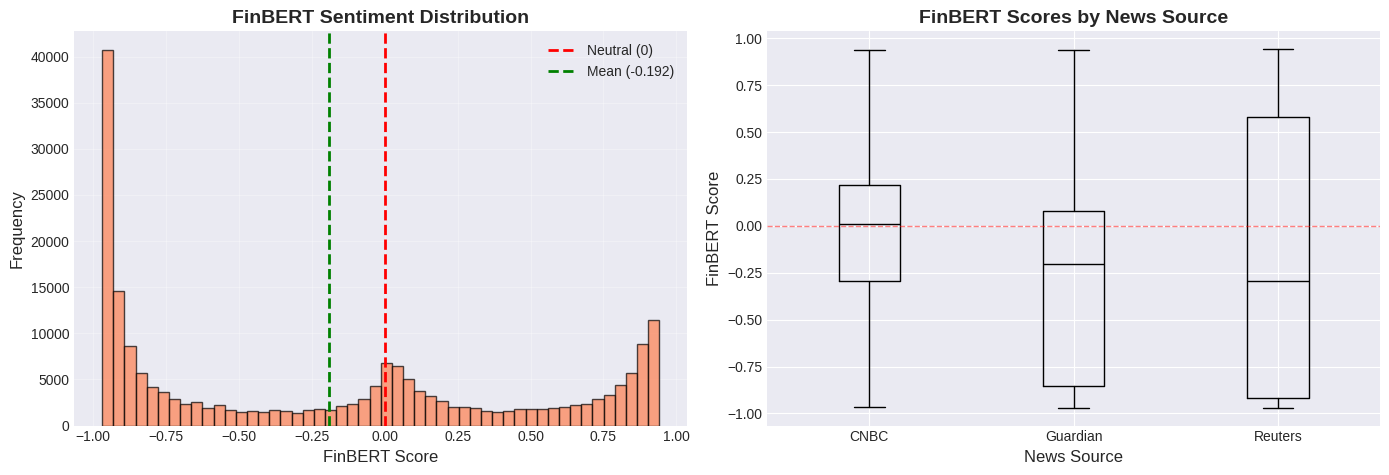


Sentiment Breakdown (using ±0.1 threshold):
  Positive: 70,869 (34.4%)
  Negative: 109,170 (53.0%)
  Neutral: 25,984 (12.6%)


In [26]:
# FinBERT score distribution
print('FinBERT Score Distribution:')
print(news_final['finbert_score'].describe())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(news_final['finbert_score'], bins=50, alpha=0.7, edgecolor='black', color='coral')
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='Neutral (0)')
axes[0].axvline(news_final['finbert_score'].mean(), color='green', linestyle='--',
                linewidth=2, label=f'Mean ({news_final["finbert_score"].mean():.3f})')
axes[0].set_xlabel('FinBERT Score', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('FinBERT Sentiment Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

news_final.boxplot(column='finbert_score', by='source', ax=axes[1], color='black')
axes[1].set_xlabel('News Source', fontsize=12)
axes[1].set_ylabel('FinBERT Score', fontsize=12)
axes[1].set_title('FinBERT Scores by News Source', fontsize=14, fontweight='bold')
axes[1].axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)
plt.suptitle('')

plt.tight_layout()
plt.show()

positive_fb = (news_final['finbert_score'] > 0.1).sum()
negative_fb = (news_final['finbert_score'] < -0.1).sum()
neutral_fb = ((news_final['finbert_score'] >= -0.1) & (news_final['finbert_score'] <= 0.1)).sum()

print('\nSentiment Breakdown (using ±0.1 threshold):')
print(f'  Positive: {positive_fb:,} ({positive_fb/len(news_final)*100:.1f}%)')
print(f'  Negative: {negative_fb:,} ({negative_fb/len(news_final)*100:.1f}%)')
print(f'  Neutral: {neutral_fb:,} ({neutral_fb/len(news_final)*100:.1f}%)')